# Data Preprocessing

For further applications, we clean up our dataset first by:
1. Eliminating series with too many missing values
2. Eliminating tickers that were inactive at the start or end of the training period
3. Interpolating missing data points if need be
4. Compute the daily returns for each ticker to normalize price series

In [1]:
# Imports, read and preview data

import pandas as pd
import matplotlib.pyplot as plt
import pickle

df = pd.read_csv("../../data/tech_stock_prices.csv")
df.set_index("Timestamp", inplace=True)

print(f"Number of stocks: {df.shape[1]}\nNumber of timestamps: {df.shape[0]}")
print(df.iloc[:,:5].head())

Number of stocks: 511
Number of timestamps: 916
                            AAOI     AAPL   ACIW   ACLS    ACMR
Timestamp                                                      
2019-05-15 04:00:00+00:00  10.01  47.7300  31.25  17.15  7.1167
2019-05-16 04:00:00+00:00   9.71  47.5200  32.07  16.95  6.3133
2019-05-17 04:00:00+00:00   9.17  47.2500  31.42  16.50  6.4133
2019-05-20 04:00:00+00:00   9.27  45.7725  31.01  15.96  5.9100
2019-05-21 04:00:00+00:00   9.52  46.6500  31.51  16.34  6.0800


In [2]:
# Percentage of NaN values per ticker

nan_percentages = df.isna().mean()[1:] * 100
print(nan_percentages)

AAPL     0.000000
ACIW     0.000000
ACLS     0.000000
ACMR     0.000000
ADBE     0.000000
          ...    
YY       0.000000
ZENV    60.152838
ZI      29.039301
ZM       0.000000
ZS       0.000000
Length: 510, dtype: float64


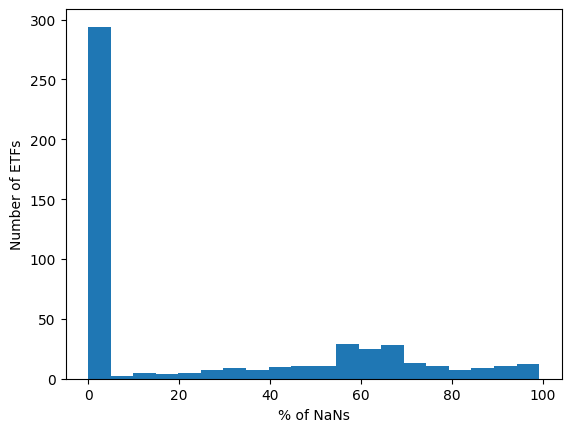

In [3]:
# Distribution of percentage of NaN values

plt.hist(nan_percentages, cumulative=False, bins=20)
plt.xlabel("% of NaNs")
plt.ylabel("Number of stocks")
plt.show()

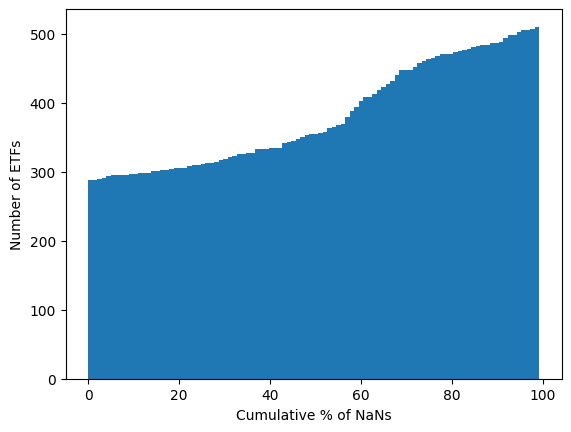

In [4]:
# Cumulative distribution of percentage of NaN values

plt.hist(nan_percentages, cumulative=True, bins=100)
plt.xlabel("Cumulative % of NaNs")
plt.ylabel("Number of stocks")
plt.show()

### Dealing with NaN values

Missing data points will skew our model results. The dataset consists of weekdays and trading hours but does not account for bank holidays and the days where the markets are closed for transactions, therefore some missing data is to be expected for every ticker. Choosing 25% as a threshold for maximum number of missing data points per ticker leaves us with a healthy boundary both in terms of number of tickers remaining and number of existing data points per ticker.

We also do not want to consider stocks that were inactive at the start of our training period or became inactive towards the end of the training period. This is for three reasons:
1. The trading period is not fully relevant for those stocks, since they were not active throughout the whole duration
2. Stocks inactive at the start of the training period cannot be interpolated, therefore they are a blocker for our imputation method of choice
3. Stocks inactive at the end of the training period cannot be traded now or in the future, becoming a blocker for testing our trading strategy in Chapter 3.

To filter them out, we employ a rather primitive approach: Checking for missing values at the first and last timestamp of the series. This approach will surely eliminate some stocks which were missing data on those specific timestamps for other reasons than being inactive, but for the sake of this experiment and the healthy number of stocks remaining after the procedure, we stick to our approach.

Lastly, for remaining missing data points in the dataset, we use linear interpolation so that the data our model receives has no missing data.

In [5]:
# Drop series with more than 25% NaN values

valid_stocks = nan_percentages[nan_percentages == 0]
df = df[valid_stocks.index]

print(f"Number of valid stocks: {len(valid_stocks)}")

Number of valid stocks: 269


In [6]:
# Drop series if first or last value is NaN

valid_columns = df.columns[df.iloc[0].notna() & df.iloc[-1].notna()]
df = df[valid_columns]

print(f"Number of valid stocks: {len(valid_columns)}")

Number of valid stocks: 269


In [7]:
# Linear interpolation to impute NaN values

# df = df.apply(pd.to_numeric, errors='coerce')
# df.interpolate(method='linear', axis=0, inplace=True)

# print(df.head())

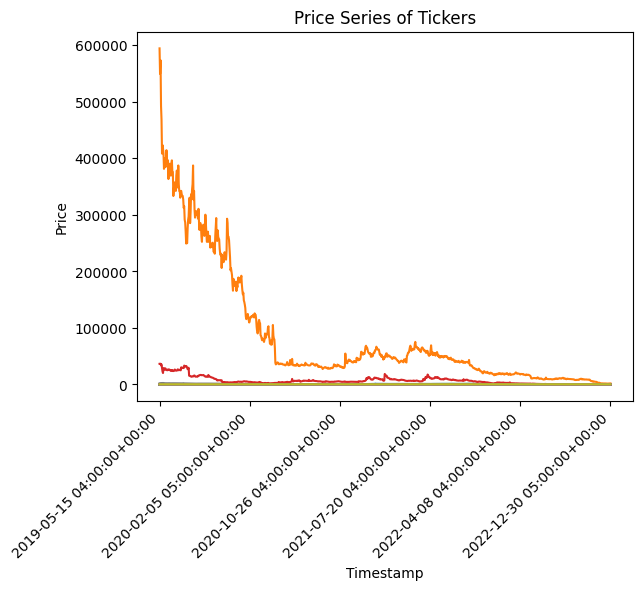

In [8]:
# Plot all remaining price series

for column in df.columns:
    plt.plot(df.index, df[column], label=column)

    # Add labels and legend
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Price Series of Tickers')
num_ticks = 5  # Specify the number of ticks you want to display
plt.xticks(df.index[::len(df.index)//num_ticks])
plt.xticks(rotation=45, ha='right')
plt.show()

### Why do we use returns instead of prices?

For the rest of our clustering approach, we will use daily returns instead of prices. Returns have multiple advantages over prices:

1. **Normalization:** Returns are often more normalized than prices themselves. Prices have different scales and nominal magnitudes, whereas returns are the relative change in prices with the same scale. Returns are more comparable, whereas absolute prices are arbitrary and dependent on outside factors such as enterprise value and outstanding shares.

2. **Stationarity & Homoskedasticity:** Returns tend to be more stationary compared to prices. They are usually homoskedastic in nature, implying that their statistical properties are independent of time and absolute prices. The volatility of returns are more stable over time whereas price changes are not.

3. **Relativity & Correlation**: Returns are relative to the price in point t-1. Absolute prices are independent of historical prices. This makes spotting correlations in prices more difficult whereas spotting correlations in returns relatively simpler.

In [9]:
# Compute returns

df_returns = df.pct_change().iloc[1:]
print(df_returns.iloc[:,:5].head())

                               AAPL      ACIW      ACLS      ACMR      ADBE
Timestamp                                                                  
2019-05-16 04:00:00+00:00 -0.004400  0.026240 -0.011662 -0.112889  0.024312
2019-05-17 04:00:00+00:00 -0.005682 -0.020268 -0.026549  0.015840 -0.013049
2019-05-20 04:00:00+00:00 -0.031270 -0.013049 -0.032727 -0.078478 -0.015723
2019-05-21 04:00:00+00:00  0.019171  0.016124  0.023810  0.028765  0.009512
2019-05-22 04:00:00+00:00 -0.020472  0.016185 -0.012240 -0.041661  0.013486


In [10]:
# Save variables in a pickle file

with open('../../data/ch0_stocks.pkl', 'wb') as f:
    pickle.dump([df, df_returns], f)